__author__ = 'Ricardo Pasquini'

# Counting tweets at the hexagon level. Complete procedure

Overview: This code counts georeferenced tweets at the hexagon level. Hexagons are uniquely identified in space. We use Uber's H3 library for this purpose.  
The code  also performs a home location prediction for each user. This allows later counting tweets by whether they were tweeted by residents, residents of neighbors hexagons, or non-residents.
The project was designed to be scalable to millions of tweets. The process is done with MongoDB.

By default the project generates the following collections on the Mongo database:

tweets: Collection containing tweets. This collection is modified by incorporating the corresponding hex id. \
users: Collection containing users. This collection is modified by incorporating the home location data.\
hexcounts: Collection containing counts of tweets.


In [25]:
import sys
sys.path.append("../") 
import databasepopulation
import communicationwmongo as commu
import home_location as home
import analysis as a
import pymongo
import pandas as pd
import my_h3_functions as myh3

In [26]:
import importlib
importlib.reload(databasepopulation)
importlib.reload(home)
importlib.reload(a)
importlib.reload(myh3)

<module 'my_h3_functions' from '..\\my_h3_functions.py'>

# Counting tweets at the hexagon level. Complete procedure

This version of the code assumes that a different database will be used for each city.


If necessary check your current location with the following command:

In [27]:
pwd

'C:\\Users\\emman\\Documents\\git\\twitter_and_displacement\\notebooks'

# 0. Connect to Mongo and define a specific database

By default connect to Mongo running on a localhost. 
Requires manually changing the parameters if working on a cloud environment

I will use the name buenosaires as the db example. Recall each database for each city.


In [28]:
db=commu.connecttoLocaldb(database='Twitter_Data')

In [29]:
db.Twitter_Data

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'Twitter_Data'), 'Twitter_Data')

# 1. Raw data to Mongo
This function populates the files containing tweets into Mongo.
Assumes files are named like: ba_2012.csv, etc.
Choose start and end years.


In [ ]:
databasepopulation.populatetweets(db, path='/Users/emman/Box/Twitter data/Asia/Sydney/', cityprefix='sydney', yearstart=2012, yearend=2012)

In [ ]:
db.tweets.update({},{'$rename':{"latitude":"lat","longitude":"lon"}}, False,True,True)

# 2. Adding Hexids to tweets 
This function includes hexagons ids to each tweet.  

In [ ]:
databasepopulation.addhexjob(db)

In [ ]:
# the following is a check and a fix because I think the previous process did not run completely, probably a bug.
# are there any other documents that were not processed?
len(list(db.tweets.find({ "hex" : { "$exists" : False } })))

In [ ]:
#Process any missing document
cursor=db.tweets.find({ "hex" : { "$exists" : False } })
df = pd.DataFrame(list(cursor))
requests = databasepopulation.add_hexs_and_prepare_bulk_request(df, dataformat='raw')
try:
    db.tweets.bulk_write(requests, ordered=False)
except BulkWriteError as bwe:
    print(bwe.details)

# 3. Database performance task: Add indexes to tweets

In [ ]:
databasepopulation.create_indexes(db)

# 4. Populate Users Collection

In [ ]:
databasepopulation.populate_users_collection(db)

# 5. Find Home Job for each user id in the database

In [ ]:
print('Users with home location identified', db.users.count_documents({'hex9': { '$exists': True} }))


# 6 Generate a Hex-level collection including all hexs in the database

By default the collection include as ids only the ids of hexagons at resolution 9
Note that many types of hexogons could coexist in a same collection because hex identifiers are unique. This is not implemented in the current version of the code, though.

In [ ]:
databasepopulation.populate_hexcounts_collection(db)

# 7 Count tweets in each hex by residents and non-residents

In [30]:
import analysis as a

In [31]:
#a.countandpopulatejob(db)

# 8 Query to the DB to create the counts dataframe 

In [38]:
import time 
start=time.time()
df=a.hexcountsresults_to_df(db, save=False)
print(time.time()-start)
# if save=True then saves resulting dataframe a pickle in ./hexcountsdf.pkl

2.070819616317749


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206078 entries, 0 to 206077
Data columns (total 7 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   _id                          206078 non-null  object        
 1   level_1                      206078 non-null  object        
 2   nonresidents                 204800 non-null  float64       
 3   nonresidentsandnonneighbors  203578 non-null  float64       
 4   residents                    32190 non-null   float64       
 5   totalcounts                  206078 non-null  float64       
 6   time                         206078 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 12.6+ MB


In [40]:
#df.to_csv('C:/Users/Emman/Desktop/Sydney_Hexes_RP.csv')

# Funcions for Spatial Analysis
### A. Transform the dataframe with hexids into a geodataframe with hexagons as geometries

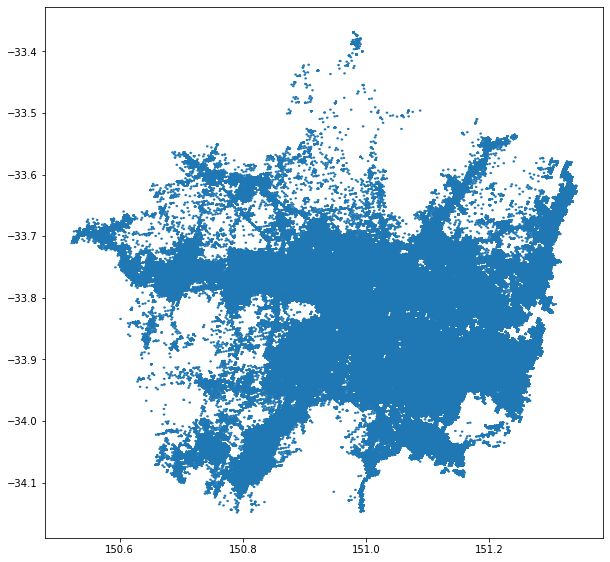

In [41]:
hexgdf = myh3.df_with_hexid_to_gdf(df, hexcolname='_id')
hexgdf.plot()

In [42]:
hexgdf.head()

,_id,level_1,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,time,geometry
0,89be08182dbffff,1404086400000,1.0,1.0,NaN,1.0,2014-06-30,"POLYGON ((150.65375 -33.98454, 150.65326 -33.9..."
1,89be08184cbffff,1380499200000,1.0,1.0,NaN,1.0,2013-09-30,"POLYGON ((150.66124 -34.02281, 150.66075 -34.0..."
2,89be08186d3ffff,1419984000000,2.0,2.0,NaN,2.0,2014-12-31,"POLYGON ((150.67178 -34.00576, 150.67129 -34.0..."
3,89be08191bbffff,1435622400000,2.0,2.0,NaN,2.0,2015-06-30,"POLYGON ((150.64530 -33.96775, 150.64481 -33.9..."
4,89be081920fffff,1356912000000,3.0,3.0,NaN,3.0,2012-12-31,"POLYGON ((150.68258 -33.93084, 150.68209 -33.9..."


## B. Transform the dataframe with hexids into a geodataframe with centoids points as geometries

#### Points can be used for spatial joins.

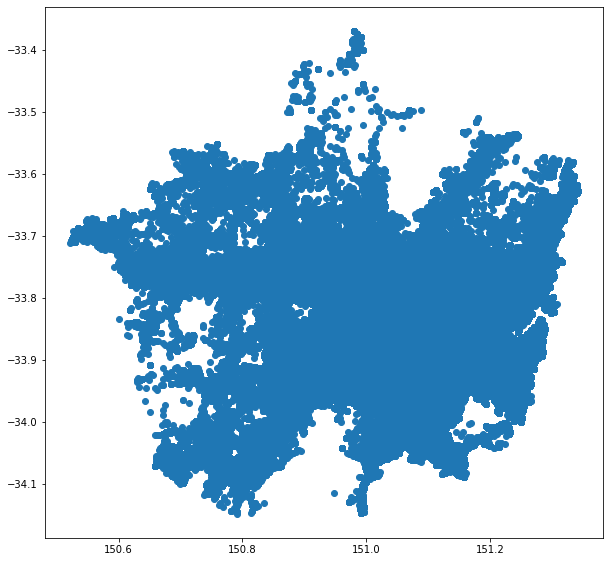

In [43]:
centroidsgdf = myh3.df_with_hexid_to_centroids_gdf(hexgdf, hexcolname='_id')
centroidsgdf.plot()

In [44]:
smooth_hexgdf = myh3.kring_smoother(hexgdf, hexcolname='_id',  metric_col='nonresidents')

MemoryError: Unable to allocate 436. MiB for an array with shape (57100776,) and data type datetime64[ns]

In [ ]:
smooth_hexgdf.info()

In [ ]:
smooth_hexgdf.plot(column='nonresidents')